In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as Data

from google.colab import drive

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
record = {"a0": "d9-db-d4-2b-d4-17", # name: right-hand MAC
          "a1": "d0-8d-fc-7f-f5-f1"} # "gui": "d0-8d-fc-7f-f5-f1" data broken! too bad.

tasks = ['sustained_soft_70',
         'sustained_strong_70',
         'iterative_soft_70',
         'iterative_strong_70']

In [ ]:
emg = []
sound_rms = []
for name in record:
    mac = record[name]
    for task in tasks:
        path = "drive/My Drive/npy-0/" + name + "/"  + task + "/"
        try:
            emg.append(np.load(path + 'emg_raw.npy'))
            sound_rms.append(np.load(path + 'sound_rms.npy'))
        except:
            pass

In [ ]:
for index, item in enumerate(emg):
    emg_temp = []
    for i in range(emg[index].shape[1]-100):
        emg_temp.append(emg[index][:,i:i+100])
    emg_temp = np.array(emg_temp)
    emg_temp = emg_temp[:int(emg_temp.shape[0] / 200) * 200,:,:]
    sound_rms[index] = sound_rms[index][:emg_temp.shape[0]]
    emg[index] = emg_temp

In [ ]:
emg_all = np.concatenate(emg, axis=0)
sound_rms_all = np.concatenate(sound_rms, axis=0)
emg_data = torch.Tensor(emg_all)
sound_rms = torch.Tensor(sound_rms_all)
print(emg_data.shape)
print(sound_rms.shape)

ValueError: ignored

In [ ]:
batch_size = 200

dataset = Data.TensorDataset(emg_data.cuda(), sound_rms.cuda())

train_loader = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()    
        self.rnn = nn.LSTM(
            input_size=100,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
        )
        self.linear = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.out = nn.Tanh()
    def forward(self, x):
        x, _ = self.rnn(x, None)
        x = self.linear(x)
        x = self.relu(x)
        x = self.out(x)
        x = torch.mean(x, dim=1).view(x.shape[0],1) # you can use a different batch size 
        return x
model = RNN()
model.cuda()
print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

RNN(
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (out): Tanh()
)


In [ ]:
for epoch in range(5):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        x = batch_x.cuda()
        y = batch_y.cuda()
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
          print("epoch {} step {} loss {}".format(epoch, step, loss.item() ) )

epoch 0 step 0 loss 0.799838662147522


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch 0 step 100 loss 0.42922890186309814
epoch 0 step 200 loss 0.35316047072410583
epoch 0 step 300 loss 0.31966376304626465
epoch 0 step 400 loss 0.33130043745040894
epoch 0 step 500 loss 0.2988954484462738
epoch 0 step 600 loss 0.28513598442077637
epoch 0 step 700 loss 0.2991149127483368
epoch 0 step 800 loss 0.3021003007888794
epoch 0 step 900 loss 0.32857024669647217
epoch 0 step 1000 loss 0.33126547932624817
epoch 1 step 0 loss 0.31798484921455383
epoch 1 step 100 loss 0.31532803177833557
epoch 1 step 200 loss 0.2946888208389282
epoch 1 step 300 loss 0.2568362355232239
epoch 1 step 400 loss 0.3133137822151184
epoch 1 step 500 loss 0.2805388569831848
epoch 1 step 600 loss 0.2700120806694031
epoch 1 step 700 loss 0.31802186369895935
epoch 1 step 800 loss 0.2912854254245758
epoch 1 step 900 loss 0.3266236484050751
epoch 1 step 1000 loss 0.30604034662246704
epoch 2 step 0 loss 0.27519139647483826
epoch 2 step 100 loss 0.2721450924873352
epoch 2 step 200 loss 0.3078756034374237
epoch 

In [ ]:
!wget https://www.uio.no/ritmo/english/people/phd-fellows/qichaol/emg_raw.npy

--2019-10-14 19:48:21--  https://www.uio.no/ritmo/english/people/phd-fellows/qichaol/emg_raw.npy
Resolving www.uio.no (www.uio.no)... 129.240.118.130
Connecting to www.uio.no (www.uio.no)|129.240.118.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1578496 (1.5M) [application/octet-stream]
Saving to: ‘emg_raw.npy.2’

emg_raw.npy.2       100%[===================>]   1.50M  6.33MB/s    in 0.2s    

2019-10-14 19:48:22 (6.33 MB/s) - ‘emg_raw.npy.2’ saved [1578496/1578496]



In [ ]:
test = np.load("emg_raw.npy")

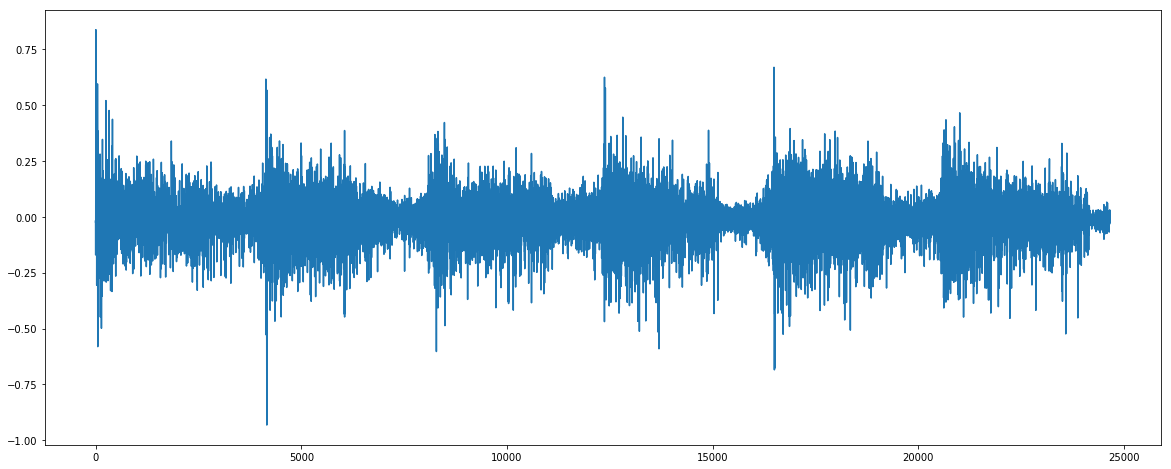

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(test[1,:])

In [ ]:
test = torch.Tensor(test).cuda()

In [ ]:
out = []
for i in range(test.shape[1]-100):
  pred = model(test[:,i:i+100].unsqueeze(0))
  pred = pred.cpu().detach().numpy()
  out.append(pred)
  if i % 1000 == 0:
    print(i)

In [ ]:
out = np.array(out)
out.shape

(24562, 1, 1)

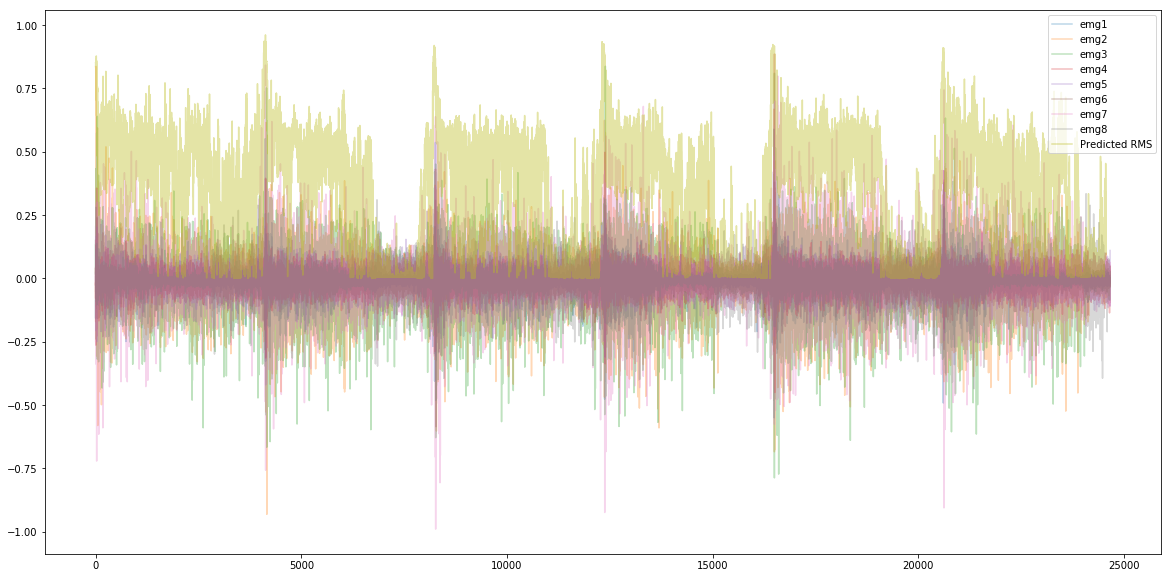

In [ ]:
plt.figure(figsize=(20,10))

for i in range(8):
#   plt.subplot(8,1,i+1)
  plt.plot(test[i,:].cpu().numpy(), label="emg"+str(i+1), alpha=0.3)
plt.plot(np.squeeze(out), label="Predicted RMS", alpha=0.4)
plt.legend(loc='upper right')  